In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

In [2]:
catalog = pd.read_csv('data/data_catalogue.csv')
data = pd.read_csv('data/data_arena_members.csv')

# Working with "catalog"

In [3]:
new_catalog = catalog[(catalog['crew_size'] >= 2) & (catalog['crew_size'] <= 6)]

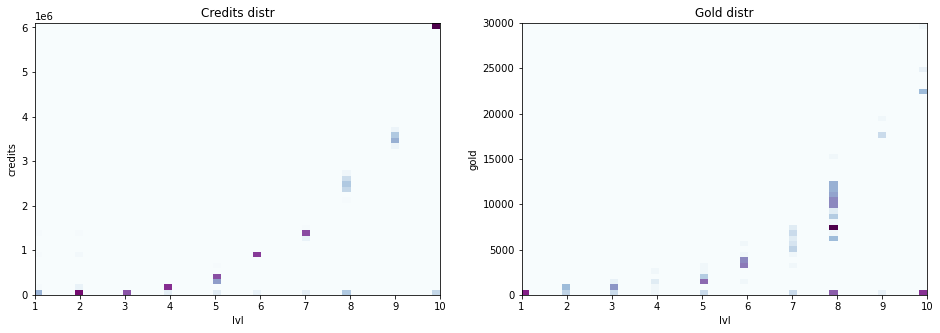

In [4]:
creds_catalog = new_catalog[new_catalog['item_price_gold'] == 0]
gold_catalog = new_catalog[new_catalog['item_price_credit'] == 0]

fig, axs = plt.subplots(1, 2, figsize=(16,5))

axs[0].hist2d(creds_catalog['item_level'], creds_catalog['item_price_credit'], bins=(50, 50), cmap=plt.cm.BuPu)
axs[0].set_title('Credits distr')
axs[0].set_xlabel('lvl')
axs[0].set_ylabel('credits')

axs[1].hist2d(gold_catalog['item_level'], gold_catalog['item_price_gold'], bins=(50, 50), cmap=plt.cm.BuPu)
axs[1].set_title('Gold distr')
axs[1].set_xlabel('lvl')
axs[1].set_ylabel('gold')

plt.show()

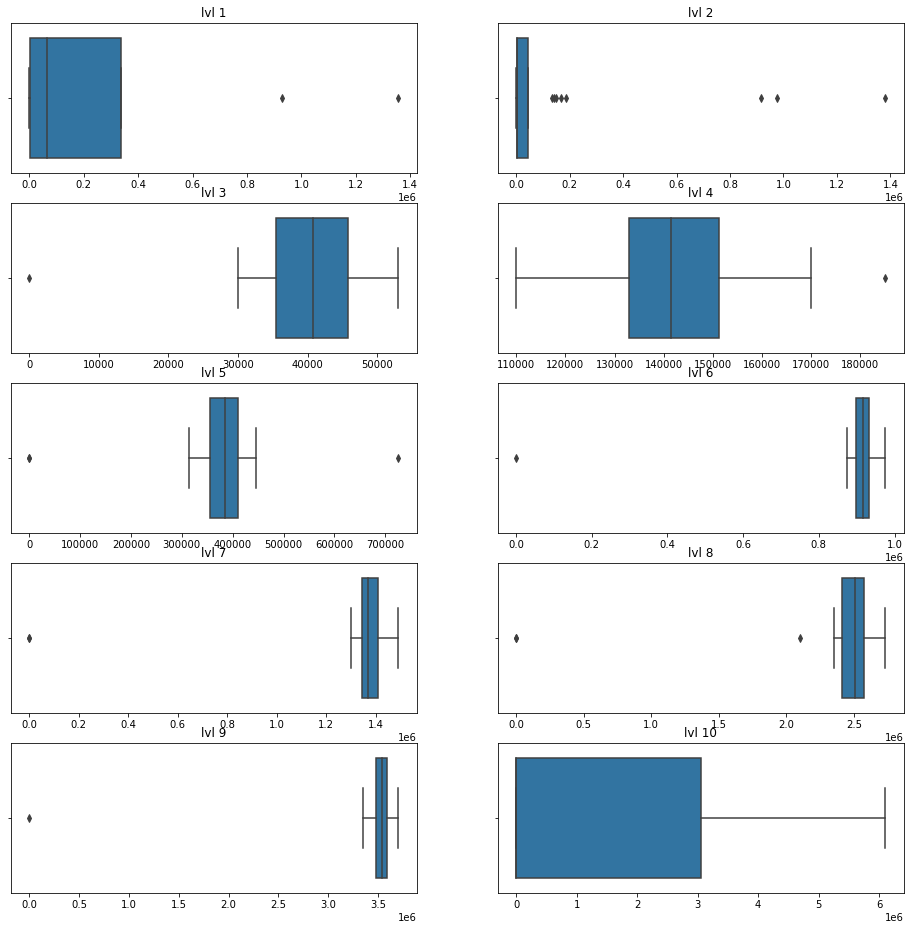

In [5]:
fig, axs = plt.subplots(5, 2, figsize=(16,16))

uniq = creds_catalog.groupby('item_level')['item_price_credit'].unique()
for i in range(5):
    for j in range(2):
        lvl = 2 * i + j + 1
        axs[i,j].set_title(f'lvl {lvl}')
        sns.boxplot(uniq[lvl], ax=axs[i, j])

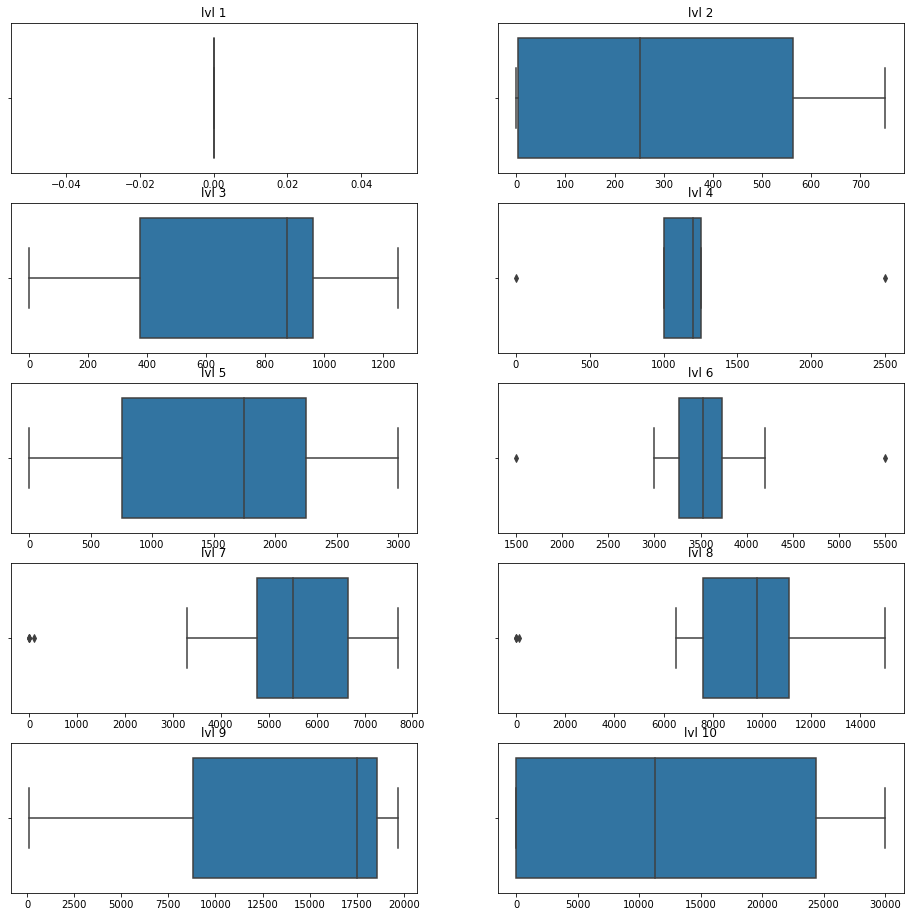

In [6]:
fig, axs = plt.subplots(5, 2, figsize=(16,16))

uniq = gold_catalog.groupby('item_level')['item_price_gold'].unique()
for i in range(5):
    for j in range(2):
        lvl = 2 * i + j + 1
        axs[i,j].set_title(f'lvl {lvl}')
        sns.boxplot(uniq[lvl], ax=axs[i, j])

In [7]:
new_catalog.head()

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,1,mediumTank,356700,0,5,4
1,17,mediumTank,373000,0,5,5
2,33,heavyTank,0,1500,5,5
3,49,mediumTank,0,7500,8,4
4,81,mediumTank,0,0,1,5


In [8]:
new_catalog.shape

(881, 6)

In [9]:
new_catalog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881 entries, 0 to 887
Data columns (total 6 columns):
item_cd              881 non-null int64
item_class           881 non-null object
item_price_credit    881 non-null int64
item_price_gold      881 non-null int64
item_level           881 non-null int64
crew_size            881 non-null int64
dtypes: int64(5), object(1)
memory usage: 48.2+ KB


## Estimate price distribution per item level

In [10]:
def disp_price_distr(data, levels, price_type):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 18))
    axes = axes.ravel()

    for index, level in enumerate(levels):
        axes[index].hist(data[data['item_level'] == level]['item_price_' + price_type], 
                         bins=10);
        axes[index].set_title('Price (' + price_type + ') - level ' + str(index + 1))

    fig.savefig(price_type + '_dist.tiff', bbox_inches = 'tight')

### Credits

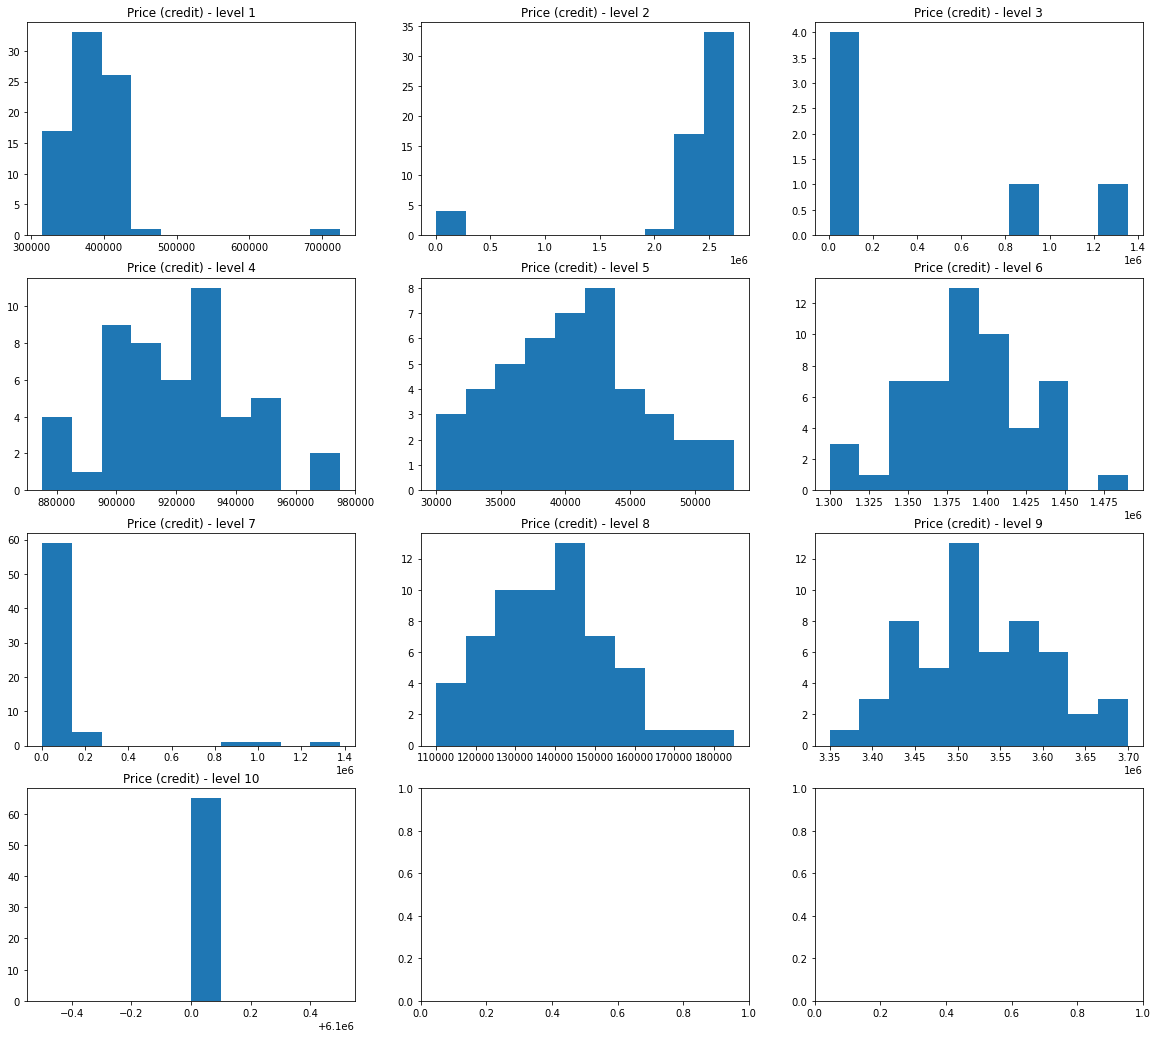

In [11]:
# Price distribution (in credits) per tank level
levels = catalog['item_level'].unique()

disp_price_distr(catalog[catalog['item_price_credit'] > 1], levels, 'credit')

### Gold

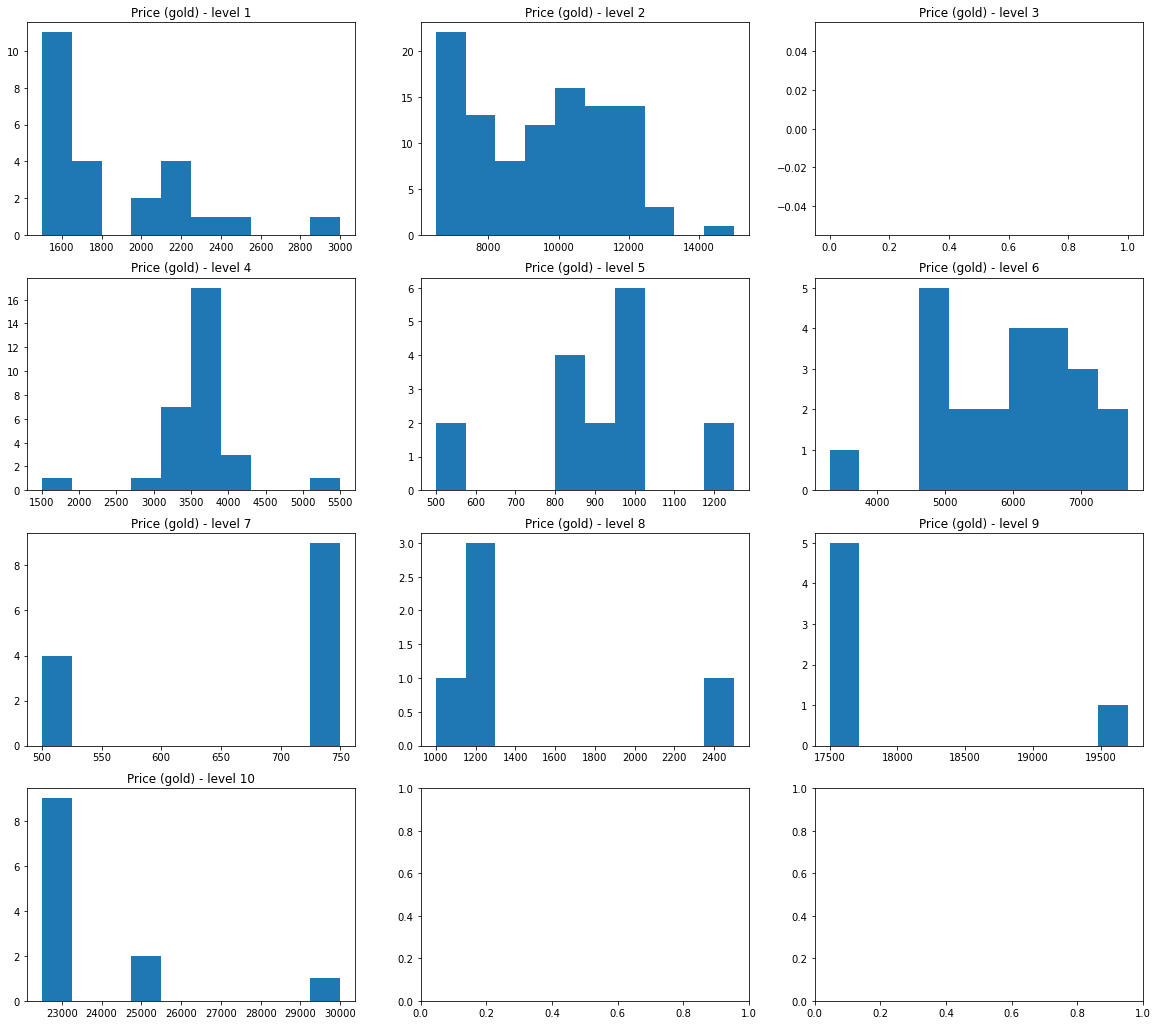

In [12]:
# Price distribution (in gold) per tank level
disp_price_distr(catalog[catalog['item_price_gold'] > 100], levels, 'gold')

## Check if there are any duplicate rows

In [13]:
# --> no duplicates
catalog.duplicated().sum()

0

## Check if there are any missing values

In [14]:
# --> no missing values
catalog.isnull().sum()

item_cd              0
item_class           0
item_price_credit    0
item_price_gold      0
item_level           0
crew_size            0
dtype: int64

## Have a closer look at some features

In [15]:
for feature in ['item_class', 'item_level']:
    catalog[feature] = pd.Categorical(catalog[feature])

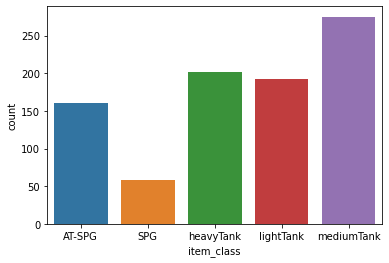

In [16]:
sns.countplot(catalog['item_class']);

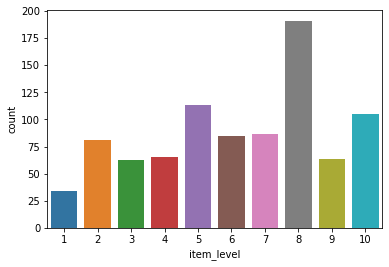

In [17]:
sns.countplot(catalog['item_level']);

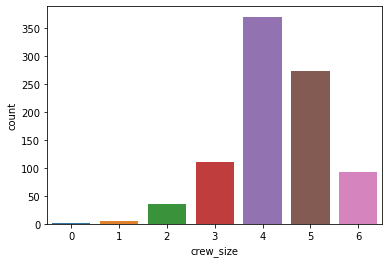

In [18]:
sns.countplot(catalog['crew_size']);

### There are a few tanks with crew_size = 0 or crew_size = 1:

> Level 1 or 10

> Cost nothing in both credits and gold (except for one)

> Mostly "lightTank"

In [19]:
catalog[(catalog['crew_size'] == 0) | (catalog['crew_size'] == 1)]

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
628,46145,lightTank,0,0,10,1
630,46353,heavyTank,0,0,10,1
762,57857,mediumTank,0,1,1,1
791,59921,SPG,0,0,1,0
880,65025,lightTank,0,0,1,1
884,65281,lightTank,0,0,1,1
886,65313,lightTank,0,0,1,0


### There are a few tanks that cost nothing in credits, as well as in gold:

> Mostly "lightTank" (23 out of 39)

> Mostly level = 1 (24 out of 39 - probably the first tanks every newcomer gets at the very beginning in WoT) and level = 10 (10 out of 39)

> crew_size varies

In [20]:
no_cost_tanks = catalog[(catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] == 0)]

In [21]:
no_cost_tanks['item_class'].value_counts()

lightTank     23
heavyTank      7
mediumTank     5
SPG            3
AT-SPG         1
Name: item_class, dtype: int64

In [22]:
no_cost_tanks['item_level'].value_counts()

1     24
10    10
5      2
7      1
3      1
2      1
9      0
8      0
6      0
4      0
Name: item_level, dtype: int64

# Working with "data" dataset

In [23]:
data.head()

,dt,arena_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,...,mileage_meter,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp
0,2018-10-27,4yNy14y4yN12d42dT,c42c4aydT,2,0,0,0,2849,132,3,...,459,-3,27279,1084,15,20,11956,0,0,0
1,2018-10-27,4yNy14y4yN12d42dT,c2TaaayN4,1,500033550,0,0,63553,195,6,...,708,0,6282,68,15,10,9832,0,0,0
2,2018-10-27,4yNy14y4yN12d42dT,cyyd47dc4,2,500051107,67896661,0,17665,224,11,...,656,0,36102,3560,15,20,39190,0,0,1130
3,2018-10-27,4yNy14y4yN12d42dT,c2cdc441y,2,0,0,0,11537,381,8,...,1912,387,16317,1678,15,20,7217,0,0,0
4,2018-10-27,4yNy14y4yN12d42dT,cdT7cTT21,1,0,0,0,7937,198,5,...,507,0,11620,232,15,10,9532,0,0,0


## Check if there are any duplicates

In [24]:
# --> no duplicates
data.duplicated().sum()

0

## Check if there are any missing values

In [25]:
#  --> no null values
data.isnull().sum()

dt                          0
arena_id                    0
account_db_id               0
team_id                     0
clan_db_id                  0
prebattle_id                0
is_prebattle_creator        0
vehicle_type_cd             0
life_time_sec               0
shots                       0
hits                        0
he_hits                     0
pierced                     0
damage_dealt                0
damage_assisted_radio       0
damage_assisted_stun        0
damage_assisted_track       0
damage_received             0
shots_received              0
no_damage_shots_received    0
pierced_received            0
spotted                     0
damaged                     0
kills_made                  0
mileage_meter               0
remained_hp                 0
original_credits            0
original_xp                 0
premium_xp_factor           0
daily_xp_factor             0
battle_num                  0
damage_blocked_by_armor     0
booster_bonus_credits       0
booster_bo

In [26]:
data.describe()

,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,hits,he_hits,pierced,...,mileage_meter,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp
count,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,...,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06
mean,1.500012e+00,2.843463e+08,7.294238e+06,7.078356e-02,2.385905e+04,2.976262e+02,7.737261e+00,5.338601e+00,3.319876e-01,3.642870e+00,...,1.172209e+03,1.898441e+02,3.101604e+04,1.051142e+03,1.499911e+01,1.359025e+01,2.330818e+04,4.413510e+02,2.001733e+03,1.087805e+02
std,5.000002e-01,2.476774e+08,2.682621e+07,2.564630e-01,2.240161e+04,1.348282e+02,5.083631e+00,4.033531e+00,1.314018e+00,3.004760e+00,...,7.146287e+02,3.944958e+02,2.388009e+04,1.048554e+03,1.153523e-01,7.431458e+00,1.681642e+04,7.220232e+02,7.045504e+03,2.797012e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-1.300000e+01,-1.037000e+03,0.000000e+00,0.000000e+00,0.000000e+00,2.501000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.377000e+03,2.010000e+02,4.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,...,6.920000e+02,0.000000e+00,1.472100e+04,3.300000e+02,1.500000e+01,1.000000e+01,1.052400e+04,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,5.000197e+08,0.000000e+00,0.000000e+00,1.334500e+04,2.870000e+02,7.000000e+00,5.000000e+00,0.000000e+00,3.000000e+00,...,1.027000e+03,0.000000e+00,2.421500e+04,6.900000e+02,1.500000e+01,1.000000e+01,1.931600e+04,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000e+00,5.000720e+08,0.000000e+00,0.000000e+00,5.019300e+04,3.740000e+02,1.000000e+01,7.000000e+00,0.000000e+00,5.000000e+00,...,1.507000e+03,1.180000e+02,3.972500e+04,1.418000e+03,1.500000e+01,2.000000e+01,3.192900e+04,6.400000e+02,0.000000e+00,0.000000e+00
max,2.000000e+00,5.001649e+08,2.687535e+08,1.000000e+00,6.528100e+04,9.000000e+02,6.300000e+01,5.100000e+01,2.700000e+01,4.000000e+01,...,1.491800e+04,3.000000e+03,3.055860e+05,1.341000e+04,1.500000e+01,4.000000e+01,2.210440e+05,1.665000e+04,1.577200e+05,3.274000e+03


## Have a closer look at some features

In [27]:
for feature in ['arena_id', 'account_db_id', 'team_id', 'clan_db_id', 
               'prebattle_id', 'is_prebattle_creator', 'vehicle_type_cd']:
    data[feature] = pd.Categorical(data[feature])
    
data['dt'] = pd.to_datetime(data['dt'])

### dt

All battles took place in October 2018 (between October 1 and October 31)

In [28]:
data['dt'].describe()

count                 1403405
unique                     31
top       2018-10-10 00:00:00
freq                    90952
first     2018-10-01 00:00:00
last      2018-10-31 00:00:00
Name: dt, dtype: object

### arena_id

47.363 unique battles were held.

There were 30 players in most battles (30 -> 20 -> 14). 
However, in some battles, a number of players was either odd (19, 13) or 
strangely small (2, 4). Are those battles connected to special events?

In [29]:
battles = data['arena_id'].value_counts()
battles

yyyyd1d41y77yN4      30
4T4yy272yyydTa2da    30
4T4yy2241TT42c1ya    30
4T4yy21d7ddN127Tc    30
4T4yy21N2NdNyN7dd    30
                     ..
71a1daddT4yN4c7       5
424y1a22T2d7T11a7     4
Ty72acc1444a4d1       3
Ty7cc77dTNNd7N4       3
4d2721ay1a7c11Nya     2
Name: arena_id, Length: 47363, dtype: int64

In [30]:
battles.to_frame()['arena_id'].value_counts()

30    45883
20     1032
14      417
19        8
13        5
12        4
22        2
18        2
3         2
21        1
17        1
24        1
7         1
6         1
5         1
4         1
2         1
Name: arena_id, dtype: int64

### account_db_id

367.746 unique players took part in battles.

In [31]:
data['account_db_id'].value_counts()

c2aTcT4y4    214
cdNcaNN77    201
c277NNN2y    140
cadaaNc77    121
c4NacTcc4     98
            ... 
caadc1121      1
cdccTT142      1
caadc1ccN      1
caadc27dd      1
c2111224a      1
Name: account_db_id, Length: 367746, dtype: int64

### team_id

Either 1 or 2

In [32]:
data['team_id'].value_counts()

2    701719
1    701686
Name: team_id, dtype: int64

### prebattle_id, is_prebattle_creator

~83% of players were not a part of any platoon

In [33]:
data[data['prebattle_id'] == 0].shape[0] / data.shape[0]

0.8267542156398189

In [34]:
data['is_prebattle_creator'].value_counts()

0    1304067
1      99338
Name: is_prebattle_creator, dtype: int64

### vehicle_type_cd

All tanks used in the battles are real (there is a corresponding entry in "catalog")

In [35]:
data['vehicle_type_cd'].describe()

count     1403405
unique        351
top         50193
freq        77041
Name: vehicle_type_cd, dtype: int64

In [36]:
data['vehicle_type_cd'].unique().isin(catalog['item_cd']).sum()

351

### Different battle characteristics

Need to be normalized to lifetime in a battle / mileage meter

In [37]:
shot_params = ['shots', 'hits', 'he_hits', 'pierced']
damage_params = ['damage_dealt', 'damage_assisted_track', 'damage_assisted_radio', 
               'damage_assisted_stun']
income_params = ['damage_received', 'shots_received', 'no_damage_shots_received',
                'pierced_received']

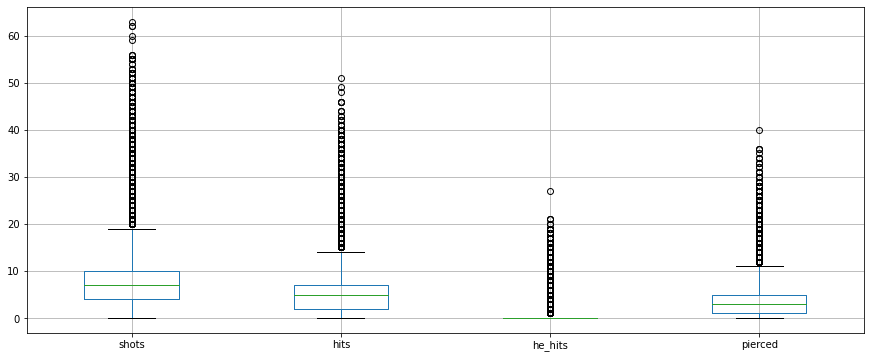

In [38]:
data[shot_params].boxplot(figsize=(15, 6));

In [39]:
data[shot_params].corr()

,shots,hits,he_hits,pierced
shots,1.000000,0.889610,0.042683,0.793251
hits,0.889610,1.000000,-0.164124,0.882728
he_hits,0.042683,-0.164124,1.000000,-0.090778
pierced,0.793251,0.882728,-0.090778,1.000000


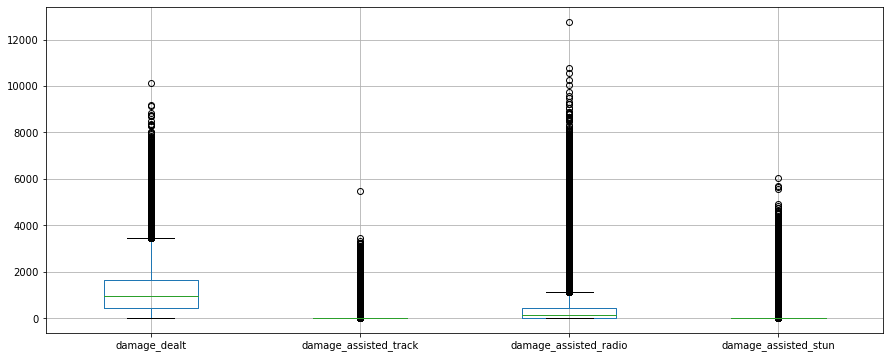

In [40]:
data[damage_params].boxplot(figsize=(15, 6));

In [41]:
data[damage_params].corr()

,damage_dealt,damage_assisted_track,damage_assisted_radio,damage_assisted_stun
damage_dealt,1.000000,0.163000,0.083237,0.052318
damage_assisted_track,0.163000,1.000000,0.032366,-0.020924
damage_assisted_radio,0.083237,0.032366,1.000000,-0.112695
damage_assisted_stun,0.052318,-0.020924,-0.112695,1.000000


In [42]:
data[income_params].describe()

,damage_received,shots_received,no_damage_shots_received,pierced_received
count,1.403405e+06,1.403405e+06,1.403405e+06,1.403405e+06
mean,1.162685e+03,5.298493e+00,1.668618e+00,3.629874e+00
std,5.269663e+02,3.593657e+00,2.452909e+00,1.881227e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.000000e+02,3.000000e+00,0.000000e+00,2.000000e+00
50%,1.300000e+03,5.000000e+00,1.000000e+00,4.000000e+00
75%,1.500000e+03,7.000000e+00,2.000000e+00,5.000000e+00
max,3.000000e+03,6.700000e+01,6.200000e+01,2.000000e+01


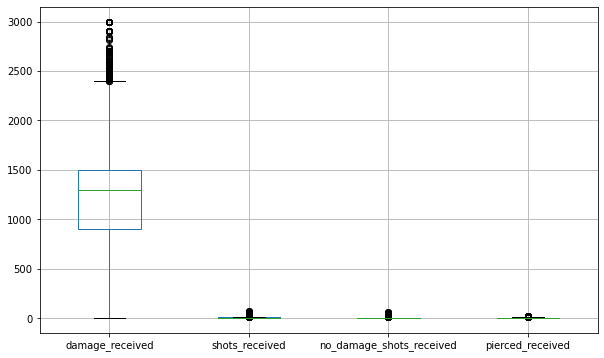

In [43]:
data[income_params].boxplot(figsize=(10, 6));

### life_time_sec

Do we need players that did not spend time in a battle at all? 
(life_time_sec = 0)

In [44]:
data[data['life_time_sec'] == 0].shape[0]

7

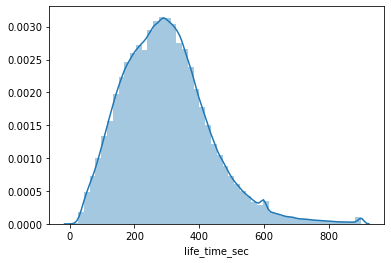

In [45]:
sns.distplot(data[data['life_time_sec'] > 0]['life_time_sec']);

### remained_hp

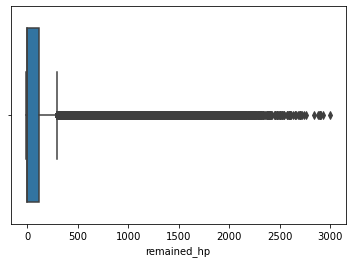

In [46]:
sns.boxplot(data['remained_hp']);

In [47]:
data_negative_hp = data[data['remained_hp'] < 0]
data_negative_hp.shape[0]

116746

### damage_dealt (total, assisted, etc.)

In [48]:
data['total_damage_dealt'] = data['damage_dealt'] + data['damage_assisted_radio'] + \
    data['damage_assisted_stun'] + data['damage_assisted_track']

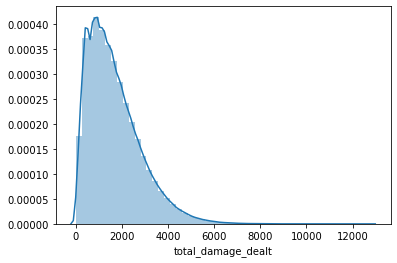

In [49]:
sns.distplot(data[data['total_damage_dealt'] > 0]['total_damage_dealt']);

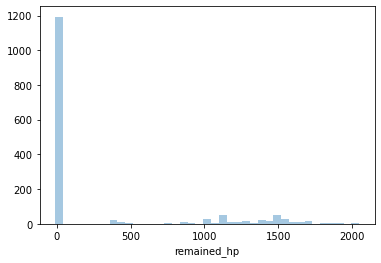

In [50]:
sns.distplot(data[(data['mileage_meter'] == 0) & (data['total_damage_dealt'] == 0)]['remained_hp'], kde=False);

In [51]:
(data[(data['mileage_meter'] == 0) & (data['total_damage_dealt'] == 0)]['damage_blocked_by_armor'] == 0).sum()

1226

### original_credits, original_xp, booster_bonus_xp, booster_bonus_credits

There is one player with original_credits < 0.

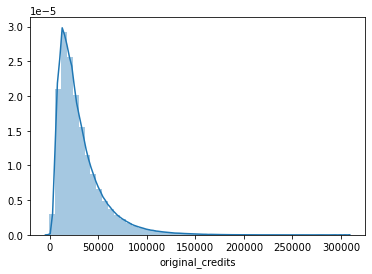

In [52]:
sns.distplot(data['original_credits']);

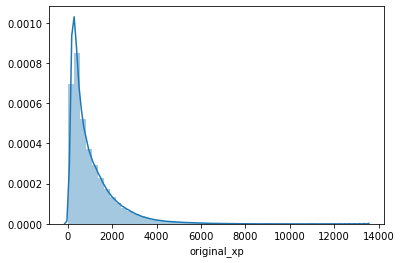

In [53]:
sns.distplot(data['original_xp']);

In [54]:
data[data['original_credits'] < 0]

,dt,arena_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,...,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp,total_damage_dealt
683724,2018-10-23,yT1Ny1yc1c77dc17T,cyN1N4Td4,1,500147675,31578326,0,5377,231,3,...,0,-1037,194,15,10,57279,0,0,0,81


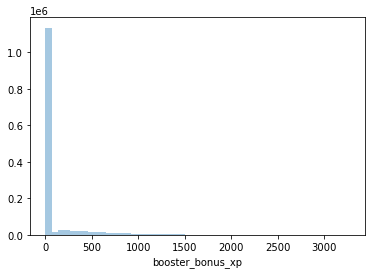

In [55]:
sns.distplot(data['booster_bonus_xp'], kde=False);

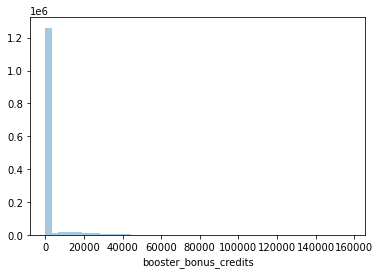

In [56]:
sns.distplot(data['booster_bonus_credits'], kde=False);

### original_xp, premium_xp_factor, daily_xp_factor, battle_num, etc.

There are 566 players that do not have a premium account

In [57]:
data['premium_xp_factor'].value_counts()

15    1403322
0          83
Name: premium_xp_factor, dtype: int64

In [58]:
data['daily_xp_factor'].value_counts()

10    1050024
20     277977
40      75321
0          83
Name: daily_xp_factor, dtype: int64

In [59]:
data['battle_num'].value_counts()

11048    84
6806     77
5935     76
3280     74
14655    74
         ..
96932     1
84642     1
88736     1
60054     1
88617     1
Name: battle_num, Length: 83343, dtype: int64

In [60]:
data[data['premium_xp_factor'] == 0]['arena_id'].isin(data[data['daily_xp_factor'] == 0]['arena_id']).sum()

83

In [61]:
data[data['original_xp'] == 0]['account_db_id'].values.unique()

[cayy4Ny4c, c4aN4y4T2, cc2Tcdyya, cyy1y7Td2, c2c2Nd111, ..., cdaTaNaad, c4427N22T, cd1744yTc, cd2N41cd2, c4ad1Nc22]
Length: 566
Categories (566, object): [cayy4Ny4c, c4aN4y4T2, cc2Tcdyya, cyy1y7Td2, ..., c4427N22T, cd1744yTc, cd2N41cd2, c4ad1Nc22]

### damage_blocked_by_armor

count    1.403405e+06
mean     4.413510e+02
std      7.220232e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.400000e+02
max      1.665000e+04
Name: damage_blocked_by_armor, dtype: float64

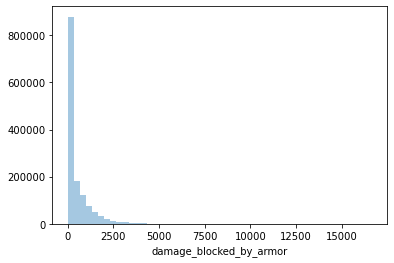

In [62]:
sns.distplot(data['damage_blocked_by_armor'], kde=False);
data['damage_blocked_by_armor'].describe()

## Create new features (normalized to time/etc) 

In [63]:
def normalize_feature(target_feature, norm_feature):
    if norm_feature != 0:
        return target_feature / norm_feature
    else:
        return 0
    
normalize_feature = np.vectorize(normalize_feature)

### Calculate additive features

In [64]:
data['total_damage_dealt'] = data['damage_dealt'] + data['damage_assisted_radio'] + \
    data['damage_assisted_stun'] + data['damage_assisted_track']

data['damage_shots_received'] = data['shots_received'] - data['no_damage_shots_received']

Turns out that data['damage_shots_received'] = data['pierced_received'], so this feature is not added.

### Normalize to time

In [65]:
target_features = ['shots', 'hits', 'he_hits', 'pierced', 'damage_dealt', 
                   'damage_assisted_track', 'damage_assisted_radio', 
                   'damage_assisted_stun', 'total_damage_dealt',
                   'damage_received', 'shots_received', 
                   'pierced_received', 'spotted', 
                   'damaged', 'kills_made', 'mileage_meter',
                   'damage_blocked_by_armor']
# target_features_normalized_sec = [feature + '_per_sec' for feature in target_features]
target_features_normalized_min = [feature + '_per_min' for feature in target_features]

In [66]:
data['life_time_min'] = data['life_time_sec'] / 60

for feature in target_features:
#     data[feature + '_per_sec'] = normalize_feature(data[feature], data['life_time_sec'])
    data[feature + '_per_min'] = normalize_feature(data[feature], data['life_time_min'])

### Compare distributions before and after normalization

#### Normalized to life_time_min

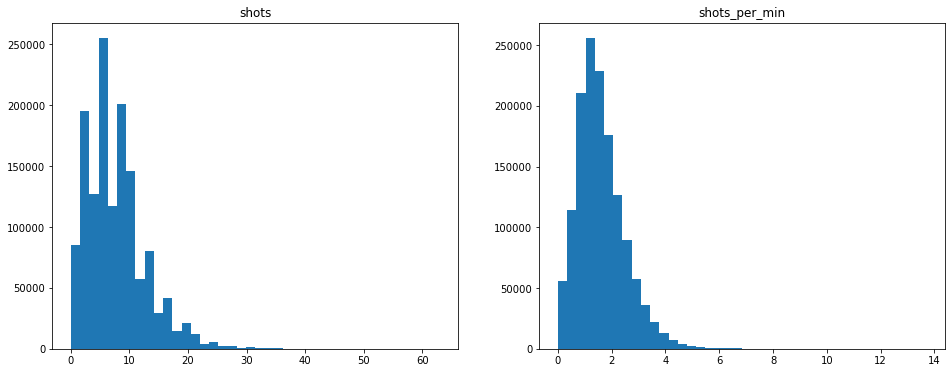

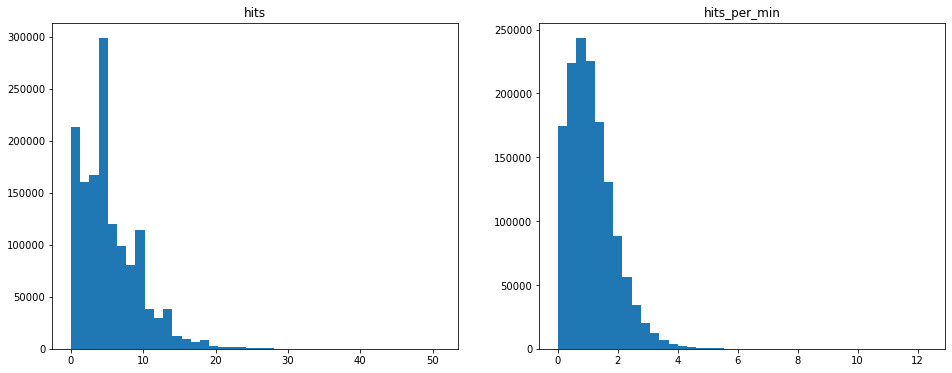

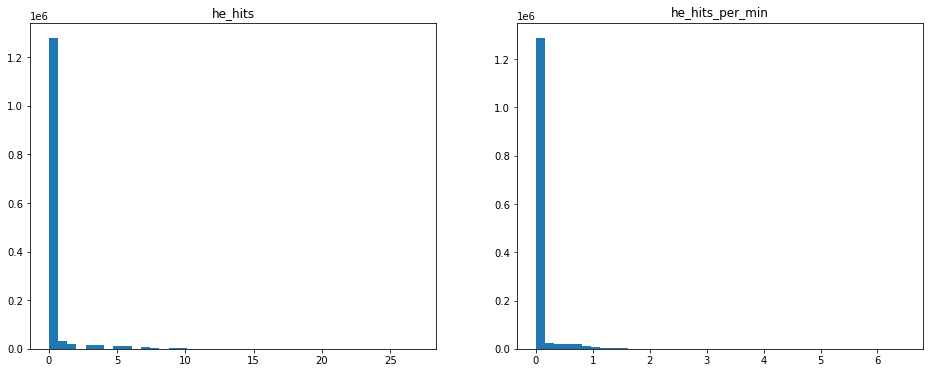

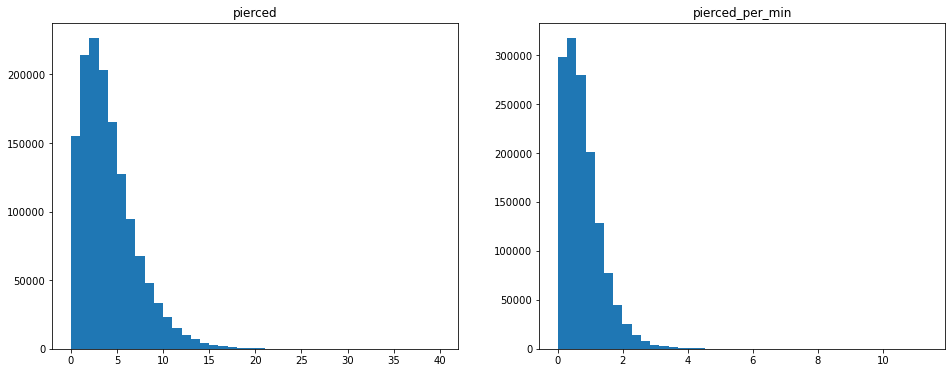

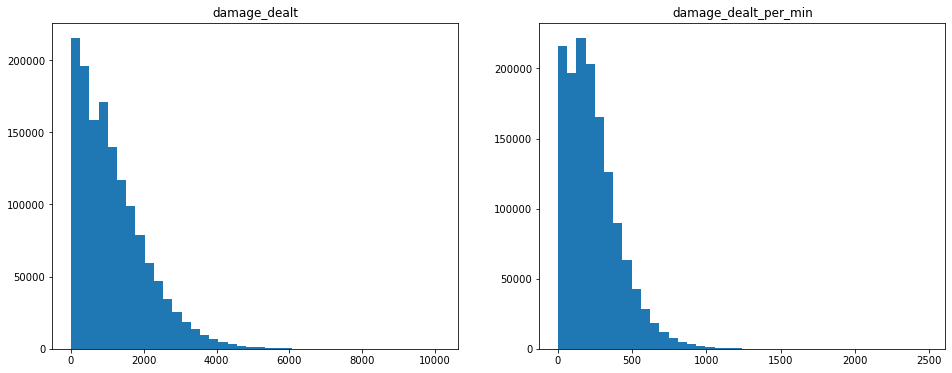

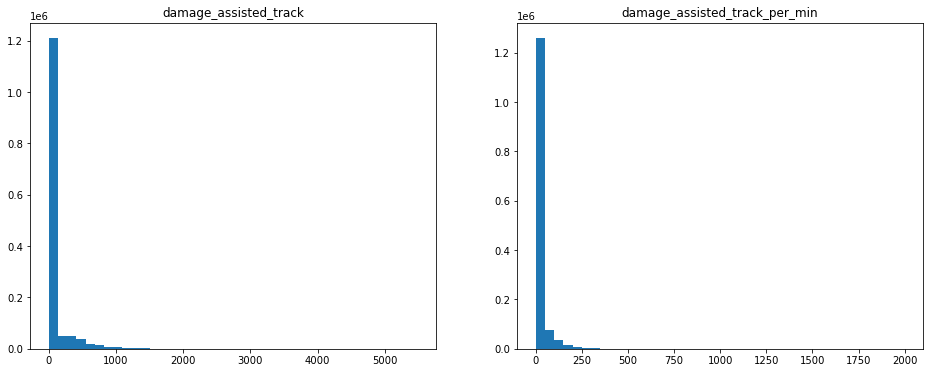

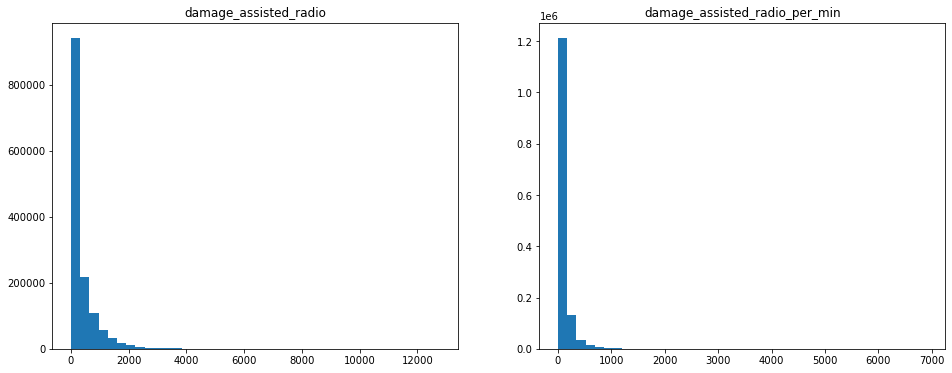

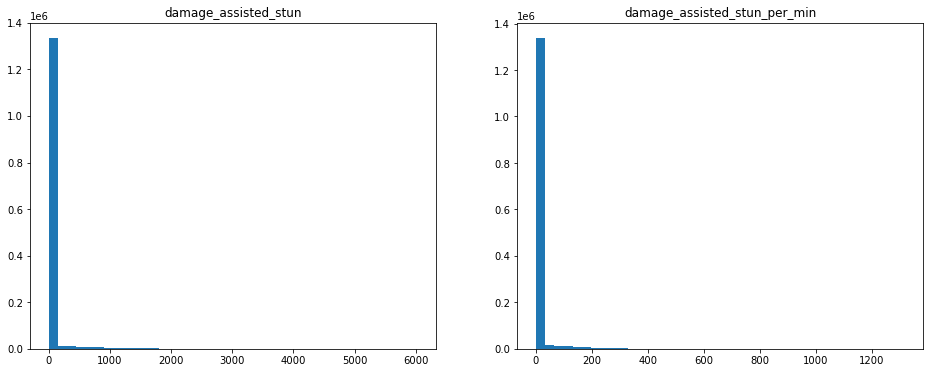

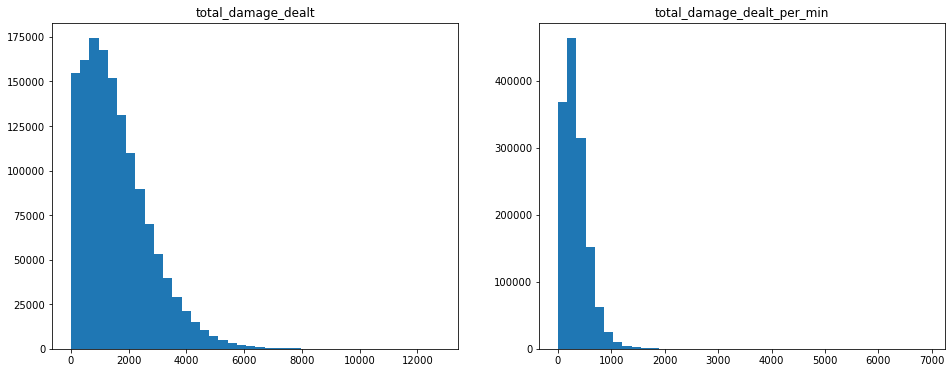

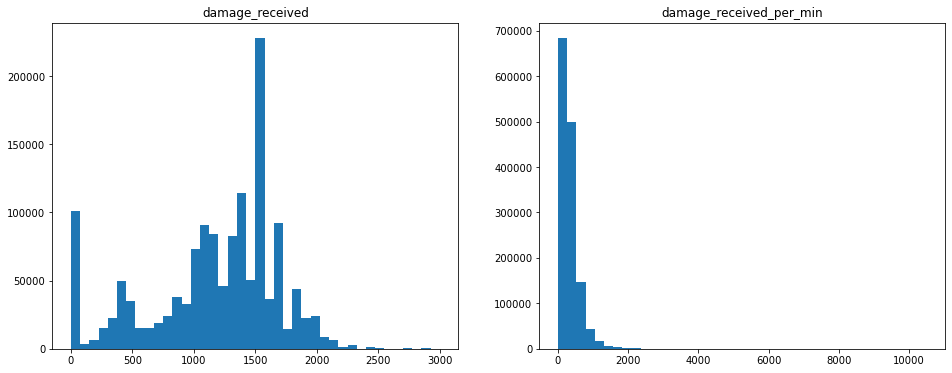

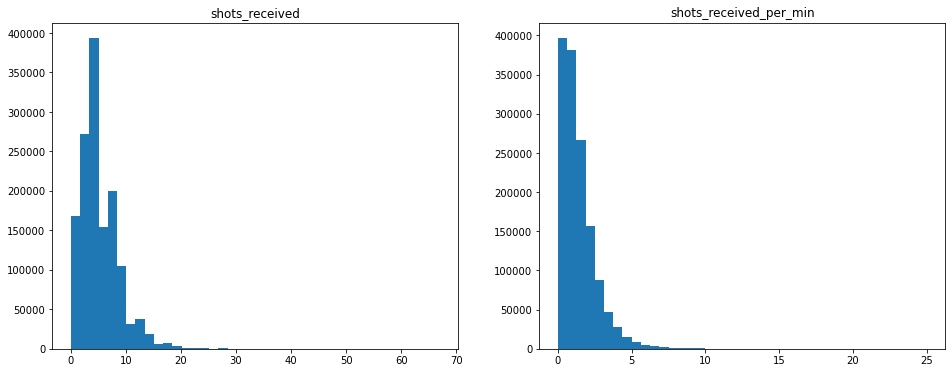

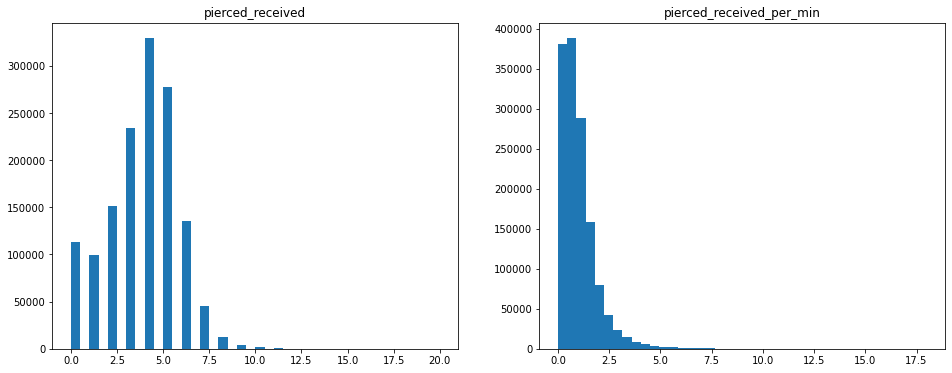

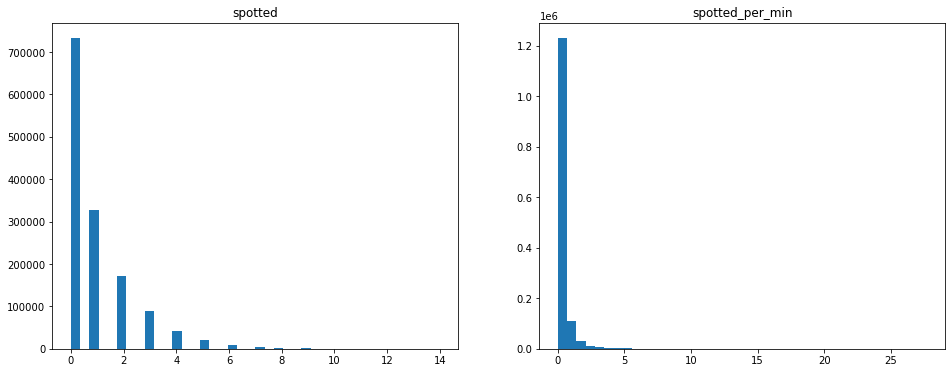

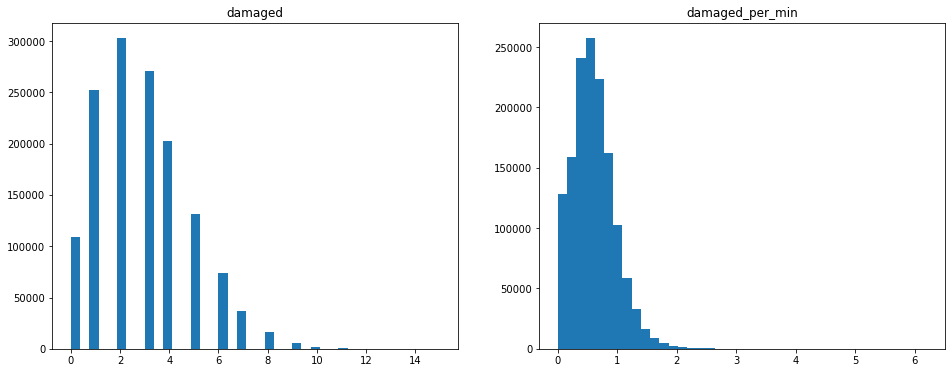

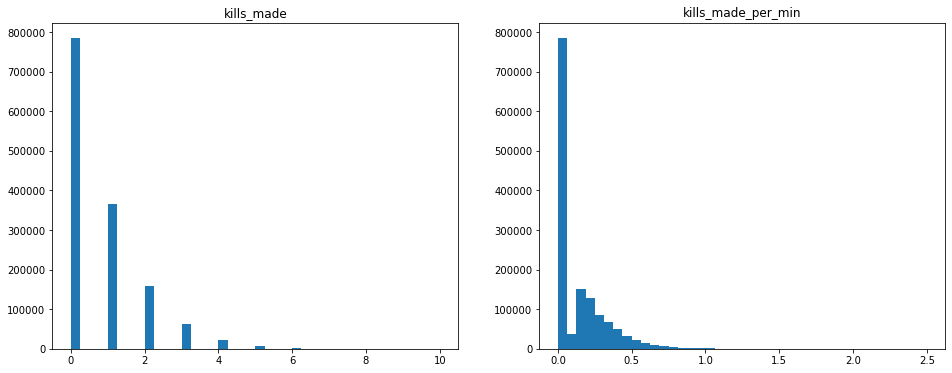

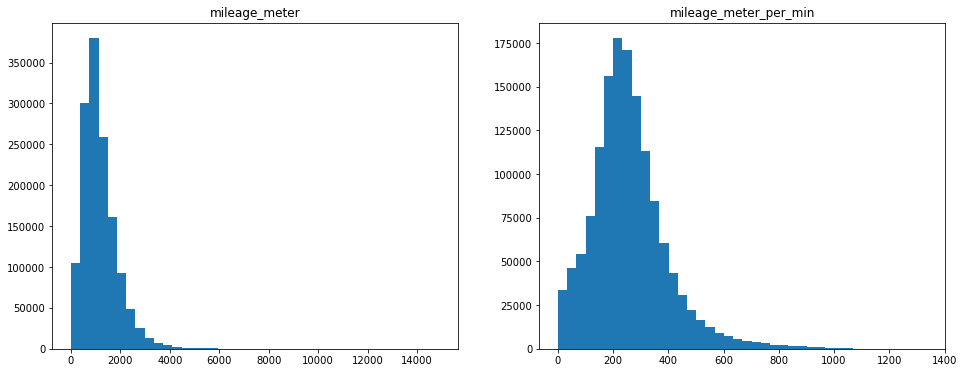

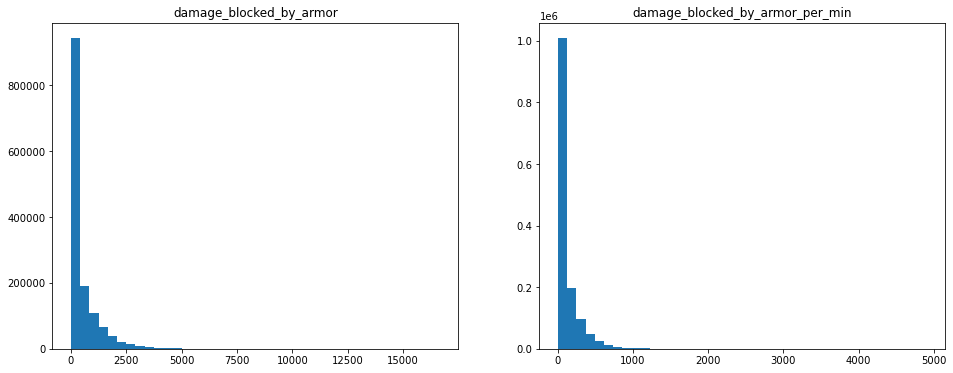

In [67]:
for feature in target_features:
    new_feature = feature + '_per_min'

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    axes[0].hist(data[feature], bins=40)
    axes[1].hist(data[new_feature], bins=40)
    
    axes[0].set_title(feature)
    axes[1].set_title(new_feature)

### Normalize to hits, shots, etc.

In [68]:
features_normalized = ['hit_rate', 'he_hit_rate', 'pierced_rate',
                      'damage_per_pierced', 'pierced_received_per_shot', 
                      'damage_per_enemy', 'damage_per_enemy_per_min', 
                      'damage_blocked_per_hit', 'damage_blocked_received_ratio']
features_num = ['hits', 'he_hits', 'pierced', 'damage_received', 
               'pierced_received', 'total_damage_dealt', 'total_damage_dealt_per_min', 
               'damage_blocked_by_armor', 'damage_blocked_by_armor']
features_denom = ['shots', 'hits', 'hits', 'pierced_received', 'shots_received', 
                 'damaged', 'damaged', 'pierced_received', 'damage_received']

In [69]:
for new_feature, feature_num, feature_denom in zip(features_normalized,
                                                  features_num, features_denom):
    data[new_feature] = normalize_feature(data[feature_num], data[feature_denom])

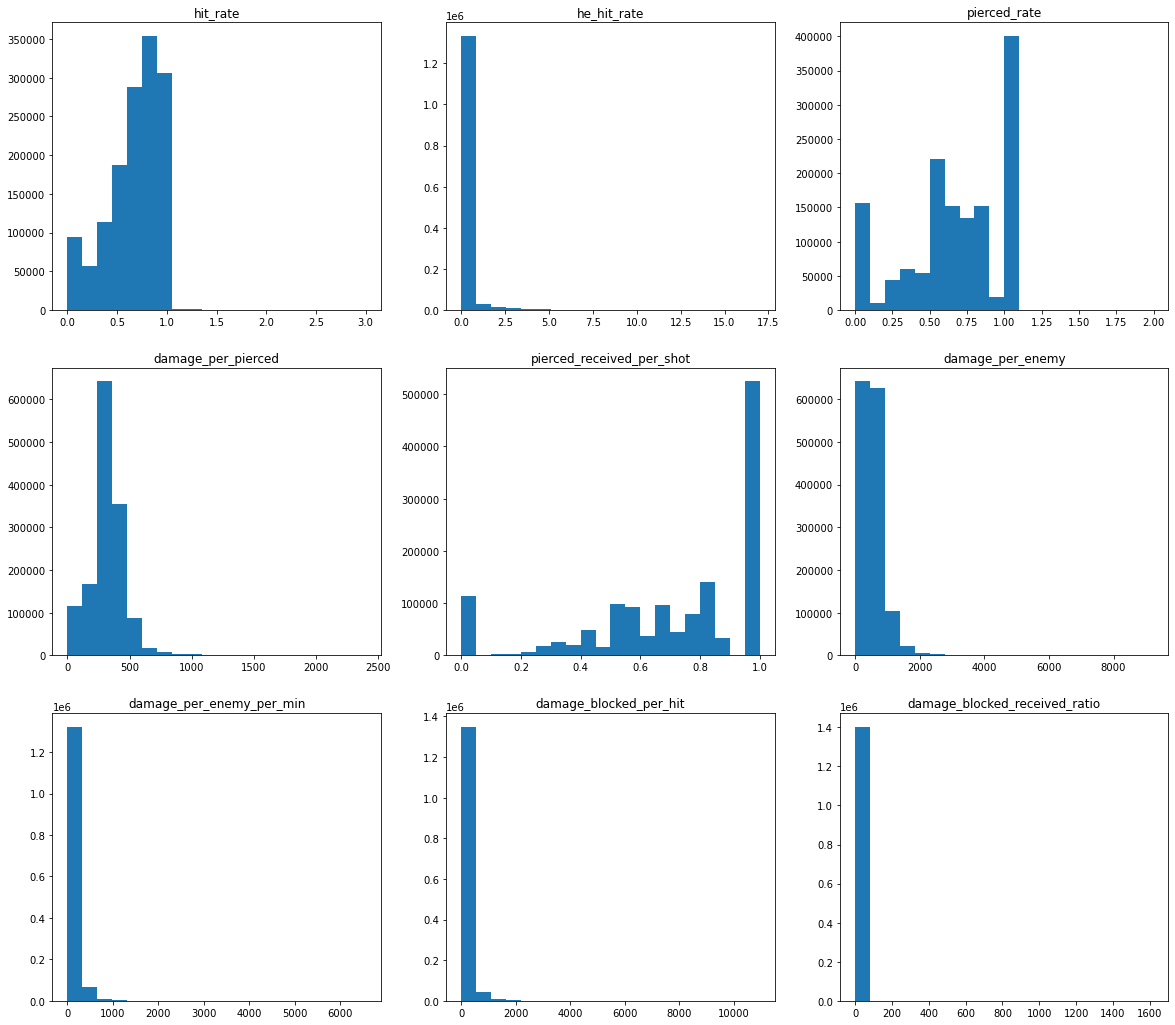

In [70]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 18))
axes = axes.ravel()

for index, feature in enumerate(features_normalized):
    axes[index].hist(data[feature], bins=20);
    axes[index].set_title(feature)

In [71]:
(data['shots_received'] - data['no_damage_shots_received']).min()

0

### Features to be removed from the dataset

In [72]:
redundant_features = ['dt', 'arena_id', 'team_id', 'clan_db_id', 'prebattle_id', 
                     'is_prebattle_creator', 'premium_xp_factor', 
                     'daily_xp_factor', 'battle_num'] + target_features

In [73]:
data.drop(redundant_features, axis=1, inplace=True)

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1403405 entries, 0 to 1403404
Data columns (total 36 columns):
account_db_id                      1403405 non-null category
vehicle_type_cd                    1403405 non-null category
life_time_sec                      1403405 non-null int64
no_damage_shots_received           1403405 non-null int64
remained_hp                        1403405 non-null int64
original_credits                   1403405 non-null int64
original_xp                        1403405 non-null int64
booster_bonus_credits              1403405 non-null int64
booster_bonus_xp                   1403405 non-null int64
life_time_min                      1403405 non-null float64
shots_per_min                      1403405 non-null float64
hits_per_min                       1403405 non-null float64
he_hits_per_min                    1403405 non-null float64
pierced_per_min                    1403405 non-null float64
damage_dealt_per_min               1403405 non-null float64

## Examining outliers

### Calculate z-scores for different features

In [ ]:
def calculate_z_score(data):
    return stats.zscore(data)

Something does not work here, check later

In [ ]:
features = data.columns.values
z_scores = np.zeros((data.shape[0], len(features)))
z_score_threshold = 3

feature_outliers = dict.fromkeys(features)

# z-scores for old features
for index, feature in enumerate(features):
    feature_outliers = calculate_z_score(data[feature])
    
    z_scores[:, index] = feature_outliers
    feature_outliers[feature] = data[feature_outliers > z_score_threshold]
    
    print(feature, feature_outliers[feature].shape[0])
    
    # Plotting feature distribution
    fig, ax = plt.subplots()
    sns.distplot(data[feature], kde=False);
    plt.axvline(feature_outliers[feature][feature].min(), ymin=0, ymax=ax.get_ylim()[1])

### Replace values

In [81]:
data.loc[data['hit_rate'] > 1, 'hit_rate'] = 1
data.loc[data['pierced_rate'] > 1, 'pierced_rate'] = 1
data.loc[data['remained_hp'] < 0, 'remained_hp'] = 1

## Merge two dataframes

In [85]:
data_merged = data.merge(catalog, how='left', left_on='vehicle_type_cd', right_on='item_cd')